# SAP Sustainability & Multidimensional Poverty Index Challenge

## Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
import plotly.express as px

In [2]:
# Load the Excel file
file_path = "SAP Datasets.xlsx"
xls = pd.ExcelFile(file_path)

# Display sheet names
xls.sheet_names


['AFE']

In [3]:
df = pd.read_excel(xls, sheet_name="AFE")
df.head()  # Preview first few rows


,Country Name,Country Code,Indicator Name,Topic,short description,long description,Indicator Code,Unit of measure,2000,2001,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,Control of Corruption: Estimate,Public Sector: Policy & institutions,NaN,NaN,CC.EST,0,NaN,NaN,...,1.014232,1.248461,1.232735,1.239377,1.207429,1.174703,1.199392,0.801611,0.756785,NaN
1,Africa Eastern and Southern,AFE,Control of Corruption: Estimate,Public Sector: Policy & institutions,NaN,NaN,CC.EST,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Control of Corruption: Estimate,Public Sector: Policy & institutions,NaN,NaN,CC.EST,0,-1.271724,NaN,...,-1.364743,-1.354240,-1.540353,-1.531910,-1.502881,-1.419499,-1.493700,-1.152327,-1.183776,NaN
3,Africa Western and Central,AFW,Control of Corruption: Estimate,Public Sector: Policy & institutions,NaN,NaN,CC.EST,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Control of Corruption: Estimate,Public Sector: Policy & institutions,NaN,NaN,CC.EST,0,-1.197514,NaN,...,-1.457798,-1.427323,-1.483337,-1.444333,-1.199251,-1.058418,-0.938673,-0.651610,-0.601941,NaN


In [4]:
print("Column Names:", df.columns)

Column Names: Index(['Country Name', 'Country Code', 'Indicator Name', 'Topic',
       'short description', 'long description', 'Indicator Code',
       'Unit of measure', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'],
      dtype='object')


## Cleaning the Data 

In [5]:
# Check for missing values
df.isnull().sum()
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Country Name             0
Country Code             0
Indicator Name           0
Topic                    0
short description    21547
long description       266
Indicator Code           0
Unit of measure          0
2000                 11765
2001                 13565
2002                 13132
2003                 13129
2004                 12912
2005                 12343
2006                 12479
2007                 12599
2008                 12500
2009                 12326
2010                 10886
2011                 11828
2012                 11686
2013                 12063
2014                 11786
2015                 11009
2016                 12103
2017                 12303
2018                 12252
2019                 11679
2020                 12707
2021                 13167
2022                 14686
2023                 21176
dtype: int64


In [6]:
# Drop columns not needed for our analysis
df = df.drop(columns=["short description", "long description"])

# Define the list of year columns (2000 to 2023) and convert them to numeric
year_columns = [str(year) for year in range(2000, 2024)]
df[year_columns] = df[year_columns].apply(pd.to_numeric, errors='coerce')

# Remove extra whitespace from key text columns
df["Country Name"] = df["Country Name"].astype(str).str.strip()
df["Indicator Name"] = df["Indicator Name"].astype(str).str.strip()


Filtered data for Afghanistan and indicator:
  Country Name Country Code                   Indicator Name  \
2  Afghanistan          AFG  Control of Corruption: Estimate   

                                  Topic Indicator Code Unit of measure  \
2  Public Sector: Policy & institutions         CC.EST               0   

       2000  2001      2002     2003  ...      2014     2015      2016  \
2 -1.271724   NaN -1.251137 -1.34418  ... -1.364743 -1.35424 -1.540353   

      2017      2018      2019    2020      2021      2022  2023  
2 -1.53191 -1.502881 -1.419499 -1.4937 -1.152327 -1.183776   NaN  

[1 rows x 30 columns]


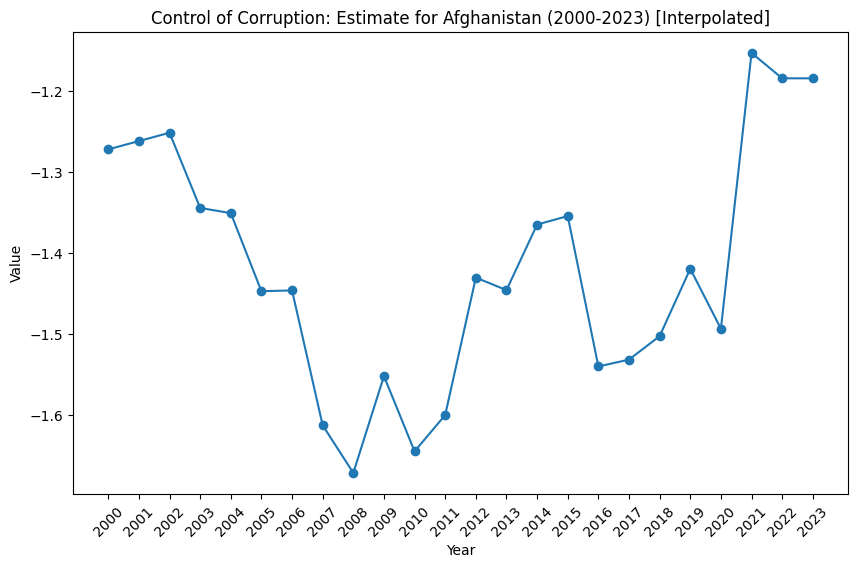

In [7]:
country = "Afghanistan"
indicator = "Control of Corruption: Estimate"

# Filter data for Afghanistan and the specified indicator
afghanistan_data = df[(df["Country Name"] == country) & (df["Indicator Name"] == indicator)]
print("Filtered data for Afghanistan and indicator:")
print(afghanistan_data)

if not afghanistan_data.empty:
    # Use years 2000 to 2023
    values = afghanistan_data[year_columns].iloc[0]
    # Interpolate to fill missing values in the time series
    values_interpolated = values.interpolate(method='linear')
    plt.figure(figsize=(10, 6))
    plt.plot(year_columns, values_interpolated, marker='o')
    plt.title(f"{indicator} for {country} (2000-2023) [Interpolated]")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.show()
else:
    print(f"No data found for {country} with indicator '{indicator}'.")

In [8]:
pivot_data = df[df["Indicator Name"] == indicator].pivot(index="Country Name", 
                                                         columns="Indicator Name", 
                                                         values="2022")
print("Pivoted data for 2022:")
print(pivot_data.head())

Pivoted data for 2022:
Indicator Name               Control of Corruption: Estimate
Country Name                                                
Afghanistan                                        -1.183776
Africa Eastern and Southern                              NaN
Africa Western and Central                               NaN
Albania                                            -0.407876
Algeria                                            -0.637930


## Constructing the Multidimensional Poverty Index

In [9]:
df["Indicator Name"].unique()

array(['Control of Corruption: Estimate',
       'Multilateral debt service (% of public and publicly guaranteed debt service)',
       'Access to clean fuels and technologies for cooking, rural (% of rural population)',
       'Access to clean fuels and technologies for cooking, urban (% of urban population)',
       'Access to clean fuels and technologies for cooking (% of population)',
       'Access to electricity, rural (% of rural population)',
       'Access to electricity, urban (% of urban population)',
       'Access to electricity (% of population)',
       'Compensation of employees (current LCU)',
       'Compensation of employees (% of expense)',
       'Adjusted savings: education expenditure (current US$)',
       'Adjusted net national income per capita (current US$)',
       'Terms of trade adjustment (constant LCU)',
       'Adequacy of social protection and labor programs (% of total welfare of beneficiary households)',
       'Adequacy of unemployment benefits and 

 For the MPI, we select three key indicators representing different dimensions:
   - Education: Literacy rate, youth (ages 15-24), gender parity index (GPI)
   - Health: Current health expenditure per capita (current US$)
   - Living Standards: Access to clean fuels and technologies for cooking (% of population)

In [10]:
# Selected indicators (these are "positive" indicators where higher is better)
education_indicator = "Literacy rate, youth (ages 15-24), gender parity index (GPI)"
health_indicator = "Current health expenditure per capita (current US$)"
living_standards_indicator = "Access to clean fuels and technologies for cooking (% of population)"
selected_indicators = [education_indicator, health_indicator, living_standards_indicator]

# Filter the dataset for these selected indicators using 2022 as the reference year
df_selected = df[df["Indicator Name"].isin(selected_indicators)]
df_pivot = df_selected.pivot_table(index="Country Name", 
                                   columns="Indicator Name", 
                                   values="2022")
# Fill missing values with the column mean
df_pivot = df_pivot.apply(lambda x: x.fillna(x.mean()), axis=0)
print("Pivoted Data for Selected Indicators (2022):")
print(df_pivot.head())

Pivoted Data for Selected Indicators (2022):
Indicator Name               Access to clean fuels and technologies for cooking (% of population)  \
Country Name                                                                                        
Afghanistan                                                          36.100000                      
Africa Eastern and Southern                                          21.863139                      
Africa Western and Central                                           22.319404                      
Albania                                                              84.600000                      
Algeria                                                              99.700000                      

Indicator Name               Current health expenditure per capita (current US$)  \
Country Name                                                                       
Afghanistan                                                        4811.679734 

 We normalize the data so that indicators with different scales become comparable.
 Since higher values for these indicators indicate better outcomes, we invert them
 (using 1 - normalized_value) so that a higher score now implies higher poverty.

In [11]:
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(df_pivot)
df_normalized = pd.DataFrame(normalized_values, columns=df_pivot.columns, index=df_pivot.index)

# we invert them (1 - normalized_value) so that a higher value reflects higher poverty.
df_inverted = 1 - df_normalized

# Compute the composite MPI as the simple average of the inverted scores
df_inverted["MPI"] = df_inverted.mean(axis=1)

# Rank countries by the adjusted MPI (higher MPI implies more multidimensional poverty)
df_ranked = df_inverted.sort_values("MPI", ascending=False)
print("\nTop 10 Countries by Adjusted MPI (Simple Average after inverting):")
print(df_ranked[["MPI"]].head(10))


Top 10 Countries by Adjusted MPI (Simple Average after inverting):
Indicator Name                   MPI
Country Name                        
Niger                       0.855383
Chad                        0.828730
Benin                       0.788741
Guinea-Bissau               0.782751
Somalia                     0.756234
Africa Western and Central  0.697301
Sierra Leone                0.682328
Congo, Dem. Rep.            0.680941
South Sudan                 0.663937
Liberia                     0.661270


## Determine the Most Influential Indicators

In [12]:
existing_indicators = [ind for ind in selected_indicators if ind in df_normalized.columns]
if len(existing_indicators) < len(selected_indicators):
    missing = set(selected_indicators) - set(existing_indicators)
    print("\nWarning: The following indicators are missing and will be excluded from PCA-based weighting:")
    print(missing)
else:
    print("\nAll selected indicators are available for PCA-based weighting.")


All selected indicators are available for PCA-based weighting.


In [13]:
pca_full = PCA(n_components=1)
pca_full.fit(df_inverted[selected_indicators])
loadings = np.abs(pca_full.components_[0])
weights = loadings / loadings.sum()  # Normalize the PCA loadings to sum to 1

print("\nPCA-based Weights for Inverted Selected Indicators:")
for ind, w in zip(selected_indicators, weights):
    print(f"{ind}: {w:.4f}")



PCA-based Weights for Inverted Selected Indicators:
Literacy rate, youth (ages 15-24), gender parity index (GPI): 0.0623
Current health expenditure per capita (current US$): 0.0059
Access to clean fuels and technologies for cooking (% of population): 0.9318


In [14]:
# Compute a PCA-weighted MPI using the inverted indicators
df_inverted["Weighted_MPI"] = (df_inverted[selected_indicators] * weights).sum(axis=1)
df_ranked_weighted = df_inverted.sort_values("Weighted_MPI", ascending=False)
print("\nTop 10 Countries by Weighted Adjusted MPI:")
print(df_ranked_weighted[["Weighted_MPI"]].head(10))


Top 10 Countries by Weighted Adjusted MPI:
Indicator Name            Weighted_MPI
Country Name                          
Guinea-Bissau                 0.972838
South Sudan                   0.958459
Burundi                       0.955588
Sierra Leone                  0.953201
Liberia                       0.951005
Central African Republic      0.949141
Guinea                        0.948209
Mali                          0.947277
Uganda                        0.945663
Niger                         0.944674



Correlation of each inverted indicator with Adjusted MPI (Simple Average):
Indicator Name
Access to clean fuels and technologies for cooking (% of population)    0.950852
Current health expenditure per capita (current US$)                     0.225124
Literacy rate, youth (ages 15-24), gender parity index (GPI)            0.444547
Weighted_MPI                                                            0.955122
Name: MPI, dtype: float64


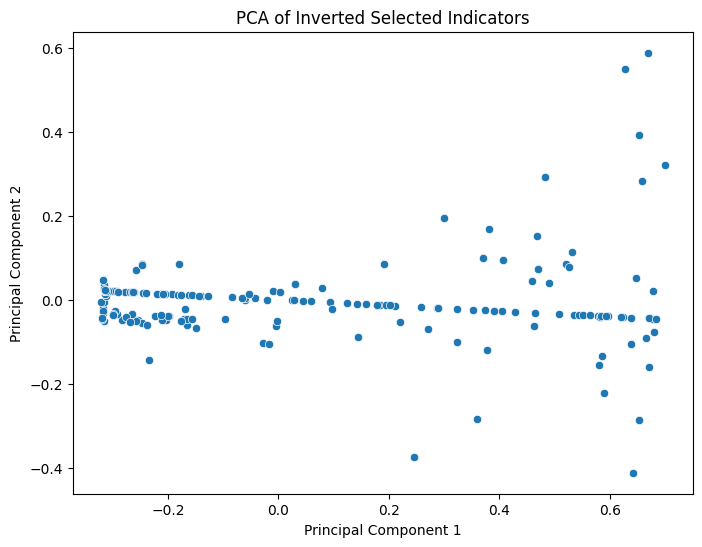


Explained Variance Ratio by PCA components:
[0.89155814 0.06234499]


In [15]:
correlations = df_inverted.corr()["MPI"].drop("MPI")
print("\nCorrelation of each inverted indicator with Adjusted MPI (Simple Average):")
print(correlations)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_inverted[selected_indicators])
pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"], index=df_inverted.index)

plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", data=pca_df)
plt.title("PCA of Inverted Selected Indicators")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

print("\nExplained Variance Ratio by PCA components:")
print(pca.explained_variance_ratio_)


## Develop Policy Recommendations

In [16]:
X = df_inverted[selected_indicators]
y = df_inverted["MPI"]
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
print("\nRandom Forest Feature Importances (Inverted Indicators):")
for ind, imp in zip(selected_indicators, importances):
    print(f"{ind}: {imp:.4f}")


Random Forest Feature Importances (Inverted Indicators):
Literacy rate, youth (ages 15-24), gender parity index (GPI): 0.0532
Current health expenditure per capita (current US$): 0.0370
Access to clean fuels and technologies for cooking (% of population): 0.9098


Based on the analysis, "Access to clean fuels and technologies for cooking (% of population)"
 emerges as the most influential indicator. This suggests that improving access to clean cooking solutions
 should be a key focus for poverty alleviation strategies.

In [17]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

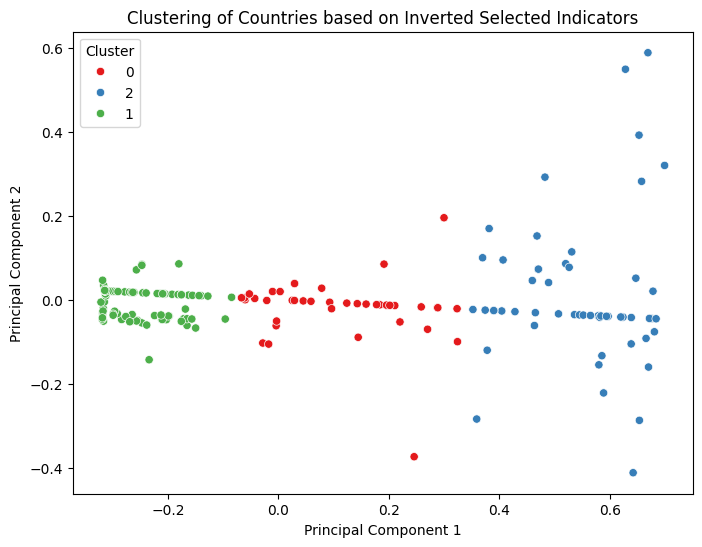


Cluster assignments (number of countries in each cluster):
Cluster
1    137
2     59
0     42
Name: count, dtype: int64


In [18]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X)
df_inverted["Cluster"] = clusters

# Visualize clusters in the PCA space
clustered_pca_df = pca_df.assign(Cluster=clusters.astype(str))
plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=clustered_pca_df, palette="Set1")
plt.title("Clustering of Countries based on Inverted Selected Indicators")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

print("\nCluster assignments (number of countries in each cluster):")
print(df_inverted["Cluster"].value_counts())

In [22]:
print("\nSummary of Findings and Policy Recommendations:")
print("--------------------------------------------------")
print("1. The composite MPI (both simple and PCA-weighted) identifies countries such as Niger, Chad, and Guinea-Bissau as highly affected.")
print("2. PCA and correlation analyses indicate that 'Access to clean fuels and technologies for cooking (% of population)' is the most influential indicator.")
print("3. The Random Forest model confirms that this indicator has the highest feature importance.")
print("4. Clustering analysis reveals distinct groups of countries with similar poverty profiles, providing a basis for tailored policy interventions.")
print("\nPolicy Recommendations:")
print("• Focus on improving access to clean cooking fuels and technologies as a priority intervention.")
print("• Develop integrated programs addressing education, health, and living standards.")
print("• Tailor interventions based on the distinct clusters of countries, ensuring that policy measures align with local challenges and sustainability goals.")
print("These insights align with SAP's commitment to sustainable development and equitable growth.")




Summary of Findings and Policy Recommendations:
--------------------------------------------------
1. The composite MPI (both simple and PCA-weighted) identifies countries such as Niger, Chad, and Guinea-Bissau as highly affected.
2. PCA and correlation analyses indicate that 'Access to clean fuels and technologies for cooking (% of population)' is the most influential indicator.
3. The Random Forest model confirms that this indicator has the highest feature importance.
4. Clustering analysis reveals distinct groups of countries with similar poverty profiles, providing a basis for tailored policy interventions.

Policy Recommendations:
• Focus on improving access to clean cooking fuels and technologies as a priority intervention.
• Develop integrated programs addressing education, health, and living standards.
• Tailor interventions based on the distinct clusters of countries, ensuring that policy measures align with local challenges and sustainability goals.
These insights align with

In [20]:
top_affected = df_ranked.head(10)
print("\nTop 10 most affected countries (highest MPI):")
print(top_affected[["MPI"]])



Top 10 most affected countries (highest MPI):
Indicator Name                   MPI
Country Name                        
Niger                       0.855383
Chad                        0.828730
Benin                       0.788741
Guinea-Bissau               0.782751
Somalia                     0.756234
Africa Western and Central  0.697301
Sierra Leone                0.682328
Congo, Dem. Rep.            0.680941
South Sudan                 0.663937
Liberia                     0.661270
